# Evaluation

This Notebook contains the evaluation of all used machine learning models during this project. \
Evaluation and Validation will be performed on the test and validation data 

In [8]:
# Imports 
import sys
sys.path.append("..")
import pandas as pd 
import matplotlib.pyplot as plt
from model.helpers import *
from model.predict import *
from collections import defaultdict
from sklearn.metrics import (
    roc_curve, auc, 
    precision_score,
    roc_auc_score,
    recall_score,
    f1_score)

from plotly.offline import init_notebook_mode
import matplotlib.pyplot as plt
import warnings  
warnings.filterwarnings('ignore')

init_notebook_mode(connected=True)

In [3]:
#load data 
TRAIN = {}
TEST = {}
VALIDATION = {}

path = "../../data/interim/raw"
train = "train_"
test = "test_"
validation = "validation_"
#  list of scenarios
scenarios = [
        'CVE-2012-2122',
        'CVE-2014-0160',
        'CVE-2017-7529',
        'CVE-2017-12635_6',
        'CVE-2018-3760',
        'CVE-2019-5418',
        'CVE-2020-9484',
        'CVE-2020-13942',
        'CVE-2020-23839',
        'CWE-89-SQL-injection'
]

for i in range(0,len(scenarios)):
    TRAIN[scenarios[i]]= pd.read_pickle(path + "/" + train + scenarios[i] + ".pkl")
    TEST[scenarios[i]] = pd.read_pickle(path + "/" + test + scenarios[i] + ".pkl")
    VALIDATION[scenarios[i]] = pd.read_pickle(path + "/" + validation + scenarios[i] + ".pkl")
            

In [4]:
# load each model for each Scenario

model_type ='IsolationForest'
IsoForests = {}
for i in range(0, len(scenarios)):
# get dict and save mofel for each scenario
    IsoForests[scenarios[i]] = load_model(model_type=model_type, data=TRAIN, scenario=scenarios[i])

model_type ='LocalOutlierFactor'
lof_ = {}
for i in range(0, len(scenarios)):
# get dict and save mofel for each scenario
    lof_[scenarios[i]] = load_model(model_type=model_type, data=TRAIN, scenario=scenarios[i])


In [5]:
# get true values to evaluate algorithm
y_true = {}
for i in range(0, len(scenarios)):
    y_true[scenarios[i]] = encode(TEST[scenarios[i]])['exploit'] # remember 0 = inliners, 1 = outliers
    # encode to fit Isolation Forest predicitons 
    y_true[scenarios[i]] = y_true[scenarios[i]].mask(y_true[scenarios[i]]==1, -1) # now # remember -1 outliers
    y_true[scenarios[i]]  = y_true[scenarios[i]].mask(y_true[scenarios[i]]==0,  1) # 1 = inliners
 

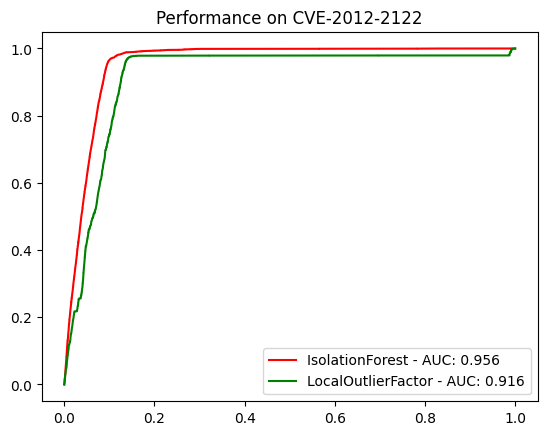

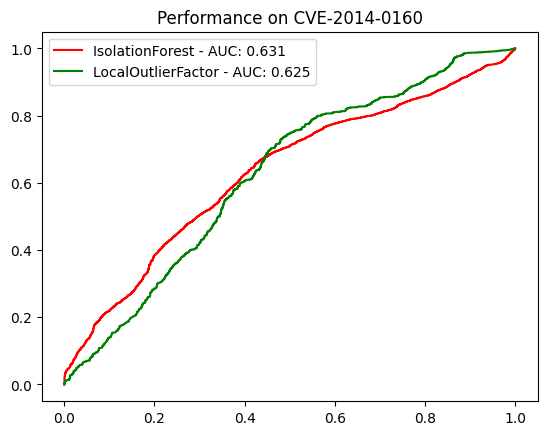

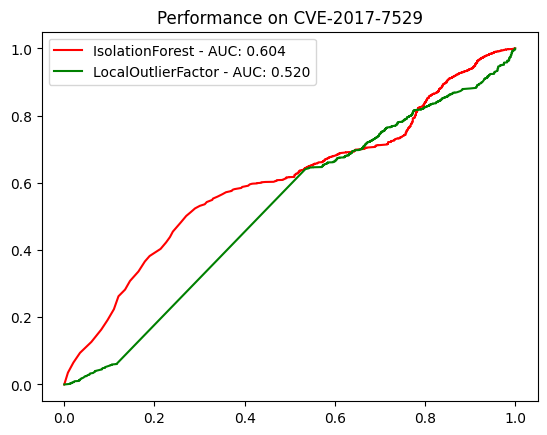

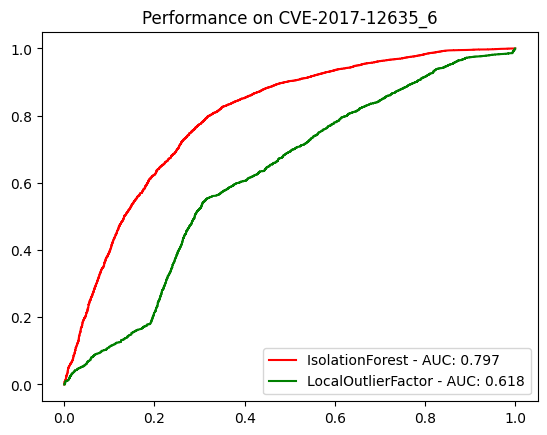

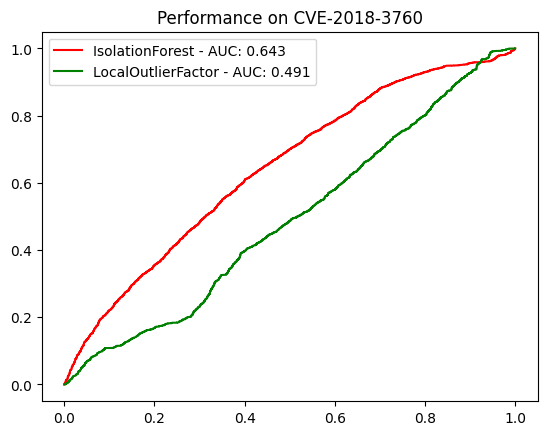

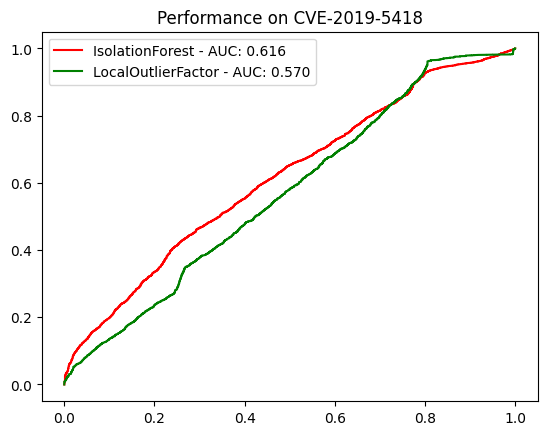

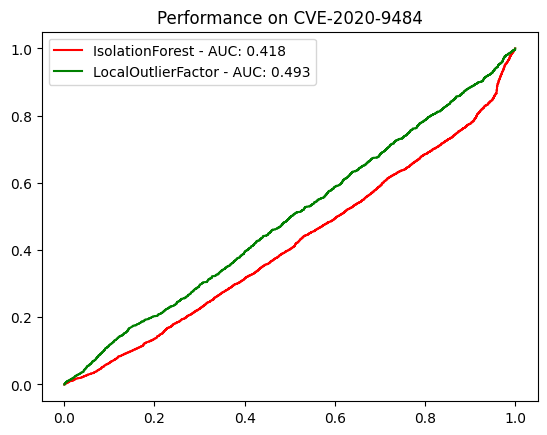

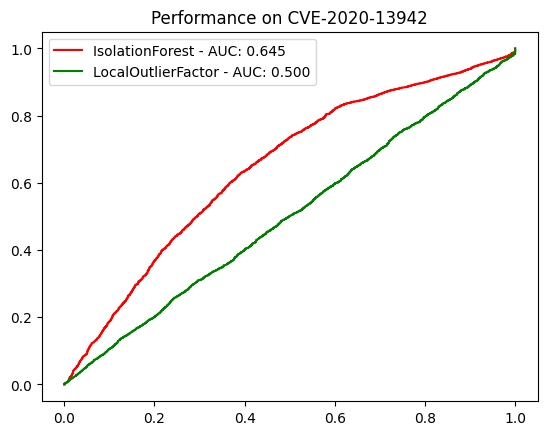

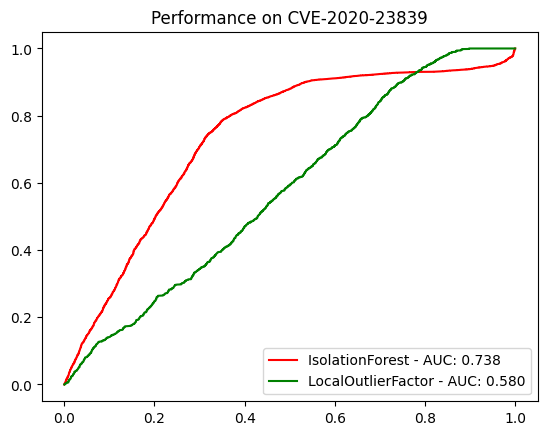

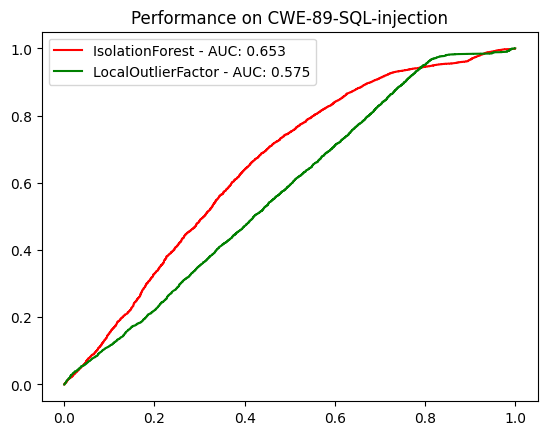

In [6]:
name = ['IsolationForest',  'LocalOutlierFactor']
colors = ['red', 'green']
# Create plots for all scenarios 
for i in range(0,len(scenarios)):
   #scenario = "CVE-2012-2122" 
   # prepare test data 
   X_test = TEST[scenarios[i]]
   X_test = select_columns_for_modelling(X_test)

   algorithms = [ IsoForests[scenarios[i]], lof_[scenarios[i]] ] 
  

   fig = plt.figure()
   for a, algo in enumerate(algorithms):
      algo_test = algo.decision_function(X_test)
   
      fpr_test_, tpr_test_, _ = roc_curve(y_true[scenarios[i]], algo_test) # Kommt drauf an wie rum(?) nochmal genau reinschauen 
      algo_auc_test = auc(fpr_test_, tpr_test_)

      
      plt.subplot(1, 1, 1)
      plt.title('Performance on ' + scenarios[i])
      plt.plot(fpr_test_, tpr_test_, color=colors[a], label= '{0} - AUC: {1:.3f}'.format(name[a], algo_auc_test)) #AMV: Augmented Mass Volume Function # AUC ohne 1
      


   plt.subplot(1, 1, 1)
   plt.legend(loc=0)
   plt.xlim((-0.05, 1.05))
   plt.ylim((-0.05, 1.05))

   plt.show()
   fig.savefig("../../src/plots/models/EVALUATION_ALLMODELS_" + scenarios[i] + ".png")

In [11]:
# Sceanrio 
scenario = 'CWE-89-SQL-injection'
X_test = TEST[scenario]
X_test = select_columns_for_modelling(X_test)
algorithms = [(IsoForests[scenario], 'IsolationForest'),(lof_[scenario],'LocalOutlierFactor')]

scores = defaultdict(list)
for i, (algo, name) in enumerate(algorithms):
    scores["Algorithm"].append(name)
    y_prediction = algo.predict(X_test)
   
    for metric in [precision_score, recall_score, f1_score, roc_auc_score]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y_true[scenario], y_prediction))

    score_df = pd.DataFrame(scores).set_index("Algorithm")
    score_df.round(decimals=3)

score_df

,Precision,Recall,F1,Roc auc
Algorithm,,,,
IsolationForest,0.918993,0.834075,0.874478,0.619393
LocalOutlierFactor,0.905911,0.824969,0.863547,0.565606


### Evaluation after Outlier Truncation